## What is the determining factor for some KPIs:

### A quick Exploratory data analysis 

In [1]:
#import the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder

In [2]:
#read the data uisng pandas 
df = pd.read_csv('case_study_data.csv')

/Users/emeka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df[['date_deposit','date_redemption']]=df[['date_deposit','date_redemption']].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d'))

In [4]:
df.describe()

,lifetime_tours,lifetime_phv_tours,pre_campaign_phv_tours,campaign_phv_tours,pas_lc_status,pas_c_status,deposits,deposits_PAS,redeemed_PAS,campaign_tours,campaign_revenue,campaign_gmv,campaign_discount_value
count,501137.000000,501137.000000,501137.000000,501137.000000,501234.000000,501234.000000,501369.000000,501369.0,501369.000000,501369.000000,94720.000000,94720.000000,94720.000000
mean,38.991609,6.510952,5.703885,0.807067,3.207097,3.084733,5.714189,1.0,0.188923,0.230447,2.351725,10.093243,2.178709
std,98.715459,15.902053,14.602252,1.953439,0.849154,1.148651,2.311474,0.0,0.391448,0.526843,1.415499,6.068438,1.638637
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.562358,2.249433,0.224943
25%,2.000000,0.000000,0.000000,0.000000,2.000000,2.000000,6.000000,1.0,0.000000,0.000000,1.359501,5.826032,0.956009
50%,8.000000,0.000000,0.000000,0.000000,3.000000,4.000000,7.000000,1.0,0.000000,0.000000,2.010431,8.604081,1.777052
75%,32.000000,6.000000,4.000000,1.000000,4.000000,4.000000,7.000000,1.0,0.000000,0.000000,2.956950,12.709297,2.811791
max,4719.000000,378.000000,341.000000,68.000000,4.000000,4.000000,7.000000,1.0,1.000000,7.000000,29.289024,128.909383,26.678276


In [5]:
##check missing variables
df.isnull().sum()/len(df)*100

camp_variant                0.000000
category                    0.000000
date_deposit                0.000000
date_redemption            81.107727
id_p                        0.000000
lifetime_tours              0.046273
lifetime_phv_tours          0.046273
pre_campaign_phv_tours      0.046273
campaign_phv_tours          0.046273
pas_lc_status               0.026926
pas_c_status                0.026926
deposits                    0.000000
deposits_PAS                0.000000
redeemed_PAS                0.000000
campaign_tours              0.000000
campaign_revenue           81.107727
campaign_gmv               81.107727
campaign_discount_value    81.107727
dtype: float64

## Finding 1
* **20%** of the customers brings all of the Sales 
* This is as a result of same amount of customer not redeeming the promo as the values are also missing.

## Feature Engineering 

In [6]:
df['days_redeem']=( df['date_redemption']-df['date_deposit']).dt.days
df['Pre_camp']= (df['pre_campaign_phv_tours']>0)*1
df['During_camp']=(df['campaign_phv_tours']>0)*1
df['Neu_Lift'] = ((df['Pre_camp']==0)& (df['During_camp']==1))*1
df['Old_Lift'] = ((df['Pre_camp']==1)& (df['During_camp']==1))*1

In [7]:
df['profit'] = df['campaign_revenue']-df['redeemed_PAS']
df['profitable'] = ((df['profit']>=1))*1


In [8]:
df['date_redemption']

0               NaT
1               NaT
2        2019-11-29
3        2019-11-29
4        2019-11-29
            ...    
501364   2019-12-11
501365   2019-12-17
501366          NaT
501367          NaT
501368   2019-12-13
Name: date_redemption, Length: 501369, dtype: datetime64[ns]

In [9]:
#from the first task
#breakdown the dates 
def datefix(column):
    #df['year']      = column.dt.year (this isn't needed here)
    #df['month']     = column.dt.month (this isn't needed here)
    df['day']       = column.dt.day
    df['dayofweek'] = column.dt.weekday
    global dowcol
    
    dowcol          = df['dayofweek']
    
    def rowclass(row):
        if row == 5 or row == 6:
            return 1 
        else:
            return 0
    df['weenend_weekday'] = dowcol.apply(rowclass)
df['date']     = pd.to_datetime(df.date_deposit, format = '%Y%m%d')
datefix(df.date_deposit)

## Revenue by Days

Text(0.5, 1.0, 'Transactions by Day')

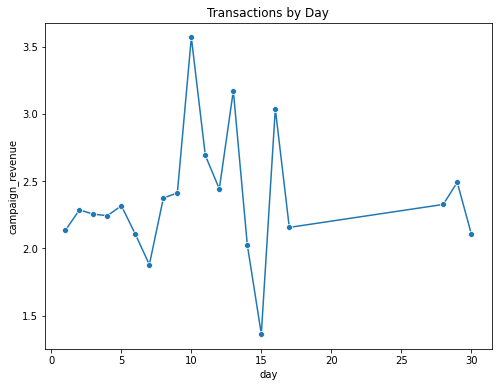

In [10]:
plt.figure(figsize=(8,6))
sns.lineplot(x = "day", y = "campaign_revenue", data = df.groupby("day").agg({"campaign_revenue":"mean"}), marker = "o", )
plt.title("Transactions by Day")

<AxesSubplot:xlabel='dayofweek', ylabel='campaign_revenue'>

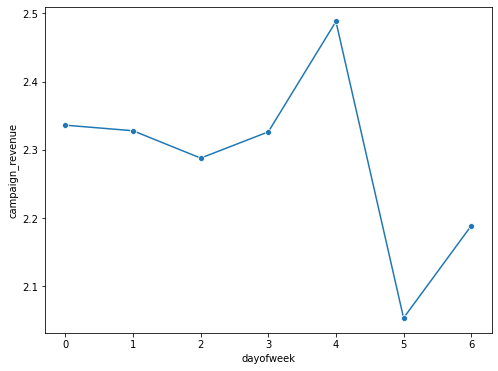

In [11]:
plt.figure(figsize=(8,6))
sns.lineplot(x = "dayofweek", y = "campaign_revenue", data = df.groupby("dayofweek").agg({"campaign_revenue":"mean"}), marker = "o", )

<AxesSubplot:xlabel='dayofweek', ylabel='campaign_tours'>

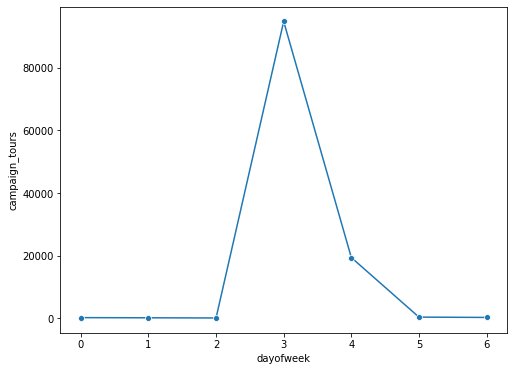

In [12]:
plt.figure(figsize=(8,6))
sns.lineplot(x = "dayofweek", y = "campaign_tours", data = df.groupby("dayofweek").agg({"campaign_tours":"sum"}), marker = "o", )

## Which camp variant redeems faster

<AxesSubplot:xlabel='camp_variant', ylabel='days_redeem'>

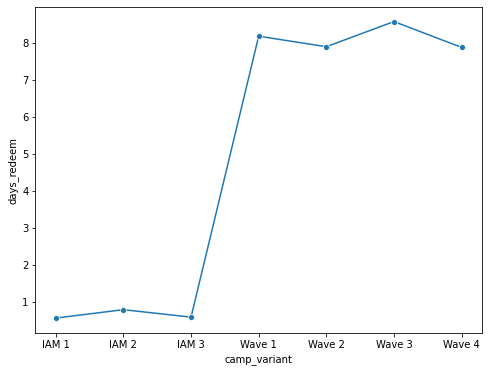

In [13]:
plt.figure(figsize=(8,6))
sns.lineplot(x = "camp_variant", y = "days_redeem", data = df.groupby("camp_variant").agg({"days_redeem":'mean'}), marker = "o", )



## Which camp has more revenue 

<AxesSubplot:xlabel='camp_variant', ylabel='campaign_revenue'>

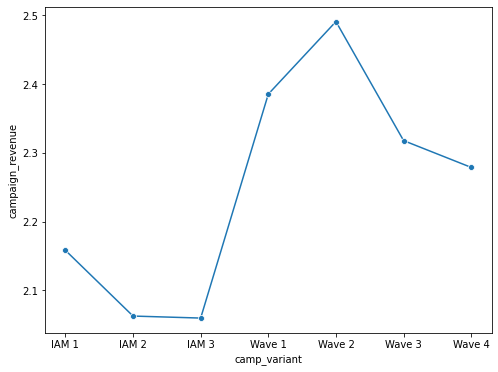

In [14]:
plt.figure(figsize=(8,6))
sns.lineplot(x = "camp_variant", y = "campaign_revenue", data = df.groupby("camp_variant").agg({"campaign_revenue":'mean'}), marker = "o", )



In [15]:
df[['id_p','date_deposit','date_redemption','lifetime_tours','lifetime_phv_tours','pre_campaign_phv_tours','campaign_phv_tours','deposits_PAS']]

,id_p,date_deposit,date_redemption,lifetime_tours,lifetime_phv_tours,pre_campaign_phv_tours,campaign_phv_tours,deposits_PAS
0,ODUwMzUxOA==,2019-11-28,NaT,105.0,9.0,9.0,0.0,1
1,ODczMjI2MA==,2019-11-28,NaT,52.0,10.0,8.0,2.0,1
2,MTA1NTQwMw==,2019-11-29,2019-11-29,67.0,2.0,0.0,2.0,1
3,MTIzNDc2NjA=,2019-11-29,2019-11-29,69.0,11.0,10.0,1.0,1
4,MTIzNzk0MzM=,2019-11-29,2019-11-29,1.0,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...
501364,MTQ5MzEzOTA=,2019-12-11,2019-12-11,351.0,8.0,6.0,2.0,1
501365,MTQ5MzEzOTA=,2019-12-11,2019-12-17,351.0,8.0,6.0,2.0,1
501366,NTU0ODM0MzQ=,2019-12-11,NaT,16.0,7.0,0.0,7.0,1
501367,NTgxNjk1ODY=,2019-12-12,NaT,1.0,1.0,0.0,1.0,1


In [16]:
#group by customer unique id
dataset= df.groupby(by='id_p', as_index=False).sum()
dataset

,id_p,lifetime_tours,lifetime_phv_tours,pre_campaign_phv_tours,campaign_phv_tours,pas_lc_status,pas_c_status,deposits,deposits_PAS,redeemed_PAS,...,days_redeem,Pre_camp,During_camp,Neu_Lift,Old_Lift,profit,profitable,day,dayofweek,weenend_weekday
0,MTA0MDAxNDA=,4.0,0.0,0.0,0.0,3.0,4.0,7,1,0,...,0.0,0,0,0,0,0.000000,0,29,4,0
1,MTA0MDE2MDY=,325.0,1.0,1.0,0.0,4.0,1.0,7,1,0,...,0.0,1,0,0,0,0.000000,0,29,4,0
2,MTA0MDE5ODQ=,86.0,2.0,2.0,0.0,4.0,4.0,7,1,0,...,0.0,1,0,0,0,0.000000,0,29,4,0
3,MTA0MDEwODA=,190.0,26.0,24.0,2.0,8.0,2.0,7,2,1,...,7.0,2,2,0,2,-0.114286,0,56,6,0
4,MTA0MDExNTc=,34.0,1.0,1.0,0.0,4.0,4.0,7,1,0,...,0.0,1,0,0,0,0.000000,0,28,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410347,OTkzODc1,56.0,2.0,0.0,2.0,8.0,8.0,7,2,1,...,6.0,0,2,2,0,0.110658,0,58,8,0
410348,OTkzODcwMA==,4.0,0.0,0.0,0.0,3.0,3.0,7,1,0,...,0.0,0,0,0,0,0.000000,0,29,4,0
410349,OTkzODk2OQ==,7.0,0.0,0.0,0.0,3.0,4.0,7,1,0,...,0.0,0,0,0,0,0.000000,0,29,4,0
410350,OTkzOTE3OQ==,237.0,0.0,0.0,0.0,4.0,3.0,7,1,0,...,0.0,0,0,0,0,0.000000,0,29,4,0


## Find the most import features
#### create the dependent variables 

In [18]:
## Redemption rate
dataset['Redemed']=(dataset['days_redeem']>=1)*1
#Retentionrate
dataset['Retain']= ((dataset['Old_Lift']==1)| (dataset['Neu_Lift']==1))

In [19]:
#Data classification
datatype = dataset.dtypes
cat_col  = datatype[(datatype == 'object') | (datatype == 'category')].index.tolist()
cal_data = dataset[cat_col]
dataset_cat=cal_data[cat_col]


### Encode the data

In [21]:
encoder = OrdinalEncoder()
# transform data
result = encoder.fit_transform(dataset_cat)
q = pd.DataFrame(data=result, columns=cat_col)
#datset drop categorical data
dataset= dataset.drop(columns= cat_col)
#add the mapped encoded categorical data
enc_dataset = pd.concat([dataset, q], axis =1)

In [22]:
#set the target and predictor variable
target1 ='Retain'
target2 = 'Redemed'
predictors1 = enc_dataset.drop(columns = [target1]).columns
predictors2 = enc_dataset.drop(columns = [target2]).columns

In [23]:
predictors = enc_dataset.columns
X1= enc_dataset[predictors1]
y1 = enc_dataset[target1]
X2= enc_dataset[predictors2]
y2 = enc_dataset[target2]

### Select the feature

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from ordered_set import OrderedSet

def get_col(model,X,y,n):
    '''
    This function uses Random forest regressor to get the important variables for the data set X and y, 
    the result are then plotted with the weighted contribution included.    
    '''
    model.fit(X,y)
    features = X.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[-n:]  # top 15 features
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
def feat_imp(model,X,y,n):
    '''
    Get values of important features.
    '''
    d=[]
    t = OrderedSet()
    importances = model.feature_importances_
    features = X.columns
    for i in range(1,n):
        j=np.argsort(importances)[-(int(i)):] 
        j[:]= j[::-1]
        u= (importances[j] *100).round(2)
        g= features[j]
        d.append(u)
        t.update(g)
    
    
    feat_import= pd.DataFrame(data=d,columns=t)
    #feat_import["sum_importance"] = feat_import.sum(axis=1)
    return feat_import


model = RandomForestClassifier(random_state=1, max_depth=10)


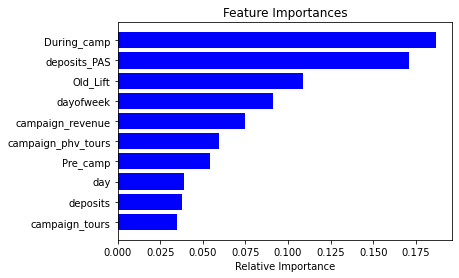

In [26]:
#Get the important festures for Retention rate
get_col(model,X1,y1,10)

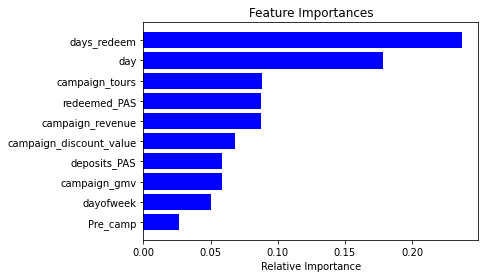

In [28]:
#Get the important festures for Redemption rate
get_col(model,X2,y2,10)